In [3]:
!pip install scikit-learn pyriemann alphawaves mne matplotlib numpy

  Using cached scikit_learn-1.7.2-cp312-cp312-macosx_10_13_x86_64.whl.metadata (11 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached mne-1.10.1-py3-none-any.whl.metadata (20 kB)
  Using cached matplotlib-3.10.6-cp312-cp312-macosx_10_13_x86_64.whl.metadata (11 kB)
  Using cached numpy-2.3.3-cp312-cp312-macosx_10_13_x86_64.whl.metadata (62 kB)
  Using cached scipy-1.16.2-cp312-cp312-macosx_10_14_x86_64.whl.metadata (62 kB)
  Using cached joblib-1.5.2-py3-none-any.whl.metadata (5.6 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
INFO: pip is looking at multiple versions of alphawaves to determine which version is compatible with other requirements. This could take a while.
  Using cached contourpy-1.3.3-cp312-cp312-macosx_10_13_x86_64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)


In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score
from pyriemann.classification import MDM
from pyriemann.estimation import Covariances
from alphawaves.dataset import AlphaWaves
import mne

/Users/argus/eegrest/lib/python3.12/site-packages/mne/externals/tempita/__init__.py:35: DeprecationWarning: 'cgi' is deprecated and slated for removal in Python 3.13
  import cgi


# Adjust settings

In [6]:
fmin, fmax = 3, 40  
sfreq = 128          
tmin, tmax = 2.0, 8.0  
event_id = {'closed': 1, 'open': 2}

# Load dataset

In [7]:
dataset = AlphaWaves()

In [8]:
accuracies = []

# Load raw data

In [15]:
for subject in dataset.subject_list:
    raw = dataset._get_single_subject_data(subject)

# Bandpass filter and resample

In [18]:
raw.filter(l_freq=fmin, h_freq=fmax, method='iir', verbose=False)
raw.resample(sfreq, verbose=False)

/Users/argus/eegrest/lib/python3.12/site-packages/mne/filter.py:2313: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  elif np.in1d(data_picks, picks).all():
/Users/argus/eegrest/lib/python3.12/site-packages/mne/filter.py:1009: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
/Users/argus/eegrest/lib/python3.12/site-packages/mne/filter.py:1009: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
/Users/argus/eegrest/lib/python3.12/site-packages/mne/filter.py:1703: DeprecationWarning: Conversion of an arr

<RawArray | 17 x 20440 (159.7 s), ~2.7 MB, data loaded>

# Event detection and epoch creation

In [19]:
events = mne.find_events(raw, shortest_event=1, verbose=False)
epochs = mne.Epochs(raw, events, event_id=event_id, tmin=tmin, tmax=tmax,baseline=None, preload=True, verbose=False)
epochs.pick_types(eeg=True)  # only EEG channels

/Users/argus/eegrest/lib/python3.12/site-packages/mne/epochs.py:415: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  The filename (if the epochs are read from disk).
/Users/argus/eegrest/lib/python3.12/site-packages/mne/epochs.py:440: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  self,


Number of events,10
Events,closed: 5open: 5
Time range,2.000 – 8.000 sec
Baseline,off


# Extracting trial data and labels

In [21]:
X = epochs.get_data()   
y = events[:, -1] 

# Classification

In [24]:
clf = make_pipeline(Covariances(estimator='lwf'), MDM())
skf = StratifiedKFold(n_splits=5)
scores = cross_val_score(clf, X, y, cv=skf)

print(f"Subject {subject} | Accuracy: {scores.mean():.2f}")
accuracies.append(scores.mean())

print("\nOverall mean accuracy across subjects:", np.mean(accuracies))

Subject 20 | Accuracy: 0.90

Overall mean accuracy across subjects: 0.9


# multiple classifiers

## loading dataset

In [27]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [28]:
dataset = AlphaWaves()
classifiers = {
    "MDM": MDM(),
    "SVM": SVC(kernel='rbf'),
    "RandomForest": RandomForestClassifier(n_estimators=100),
    "LogisticRegression": LogisticRegression(max_iter=1000)
}

## loop, events, epoch and classifiers

In [32]:
from pyriemann.utils.base import logm

In [33]:
results = {name: [] for name in classifiers.keys()}

for subject in dataset.subject_list:
    raw = dataset._get_single_subject_data(subject)
    raw.filter(l_freq=fmin, h_freq=fmax, method='iir', verbose=False)
    raw.resample(sfreq, verbose=False)

    events = mne.find_events(raw, shortest_event=1, verbose=False)
    epochs = mne.Epochs(raw, events, event_id=event_id, tmin=tmin, tmax=tmax,
                        baseline=None, preload=True, verbose=False)
    epochs.pick_types(eeg=True)

    X = epochs.get_data()
    y = events[:, -1]
    skf = StratifiedKFold(n_splits=5)
 # Compute covariance matrices
    cov = Covariances(estimator='lwf').fit_transform(X)

    # Vectorize covariance for standard classifiers
    cov_vec = np.array([logm(cov_i).flatten() for cov_i in cov])

    for name, clf in classifiers.items():
        if name == "MDM":
            pipe_X = cov  # MDM can handle 3D covariance matrices
        else:
            pipe_X = cov_vec  # Other classifiers need 2D
        pipe = make_pipeline(clf)
        scores = cross_val_score(pipe, pipe_X, y, cv=skf)
        results[name].append(scores.mean())

/Users/argus/eegrest/lib/python3.12/site-packages/mne/filter.py:2313: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  elif np.in1d(data_picks, picks).all():
/Users/argus/eegrest/lib/python3.12/site-packages/mne/filter.py:1009: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
/Users/argus/eegrest/lib/python3.12/site-packages/mne/filter.py:1009: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
/Users/argus/eegrest/lib/python3.12/site-packages/mne/filter.py:1703: DeprecationWarning: Conversion of an arr

## results

In [34]:
for name in classifiers.keys():
    mean_acc = np.mean(results[name])
    print(f"{name} | Overall mean accuracy across subjects: {mean_acc:.2f}")

MDM | Overall mean accuracy across subjects: 0.97
SVM | Overall mean accuracy across subjects: 0.97
RandomForest | Overall mean accuracy across subjects: 0.99
LogisticRegression | Overall mean accuracy across subjects: 0.98


## per subject accuracy bar plot

In [36]:
import matplotlib.pyplot as plt
import numpy as np

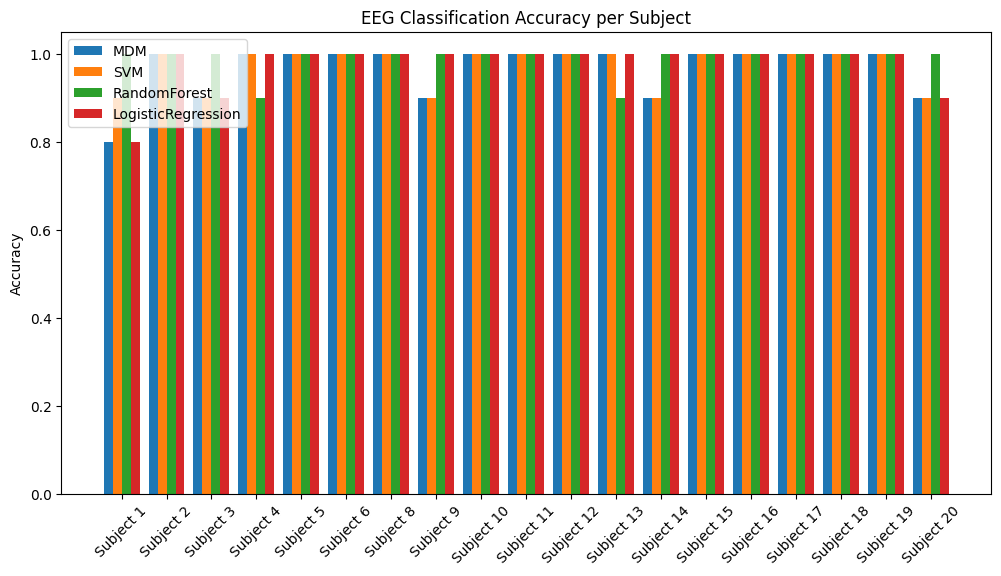

In [38]:
subjects = dataset.subject_list

plt.figure(figsize=(12,6))
bar_width = 0.2
indices = np.arange(len(subjects))

for i, (name, acc) in enumerate(results.items()):
    plt.bar(indices + i*bar_width, acc, bar_width, label=name)

plt.xticks(indices + bar_width*1.5, [f'Subject {s}' for s in subjects], rotation=45)
plt.ylabel('Accuracy')
plt.title('EEG Classification Accuracy per Subject')
plt.ylim([0, 1.05])
plt.legend()
plt.show()

In [60]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [54]:
# Flatten data for classifiers that require 2D input
X_flat = X.reshape(X.shape[0], -1)  # trials × (channels*timepoints)

# Define pipelines
mdm_pipe = make_pipeline(Covariances(estimator='lwf'), MDM())
svm_pipe = make_pipeline(SVC(kernel='rbf'))  # works on X_flat
rf_pipe = make_pipeline(RandomForestClassifier(n_estimators=100))
lr_pipe = make_pipeline(LogisticRegression(max_iter=1000))

In [62]:
from sklearn.model_selection import cross_val_predict

In [63]:
y_pred_mdm = cross_val_predict(mdm_pipe, X, y, cv=5)
y_pred_svm = cross_val_predict(svm_pipe, X_flat, y, cv=5)
y_pred_rf = cross_val_predict(rf_pipe, X_flat, y, cv=5)
y_pred_lr = cross_val_predict(lr_pipe, X_flat, y, cv=5)

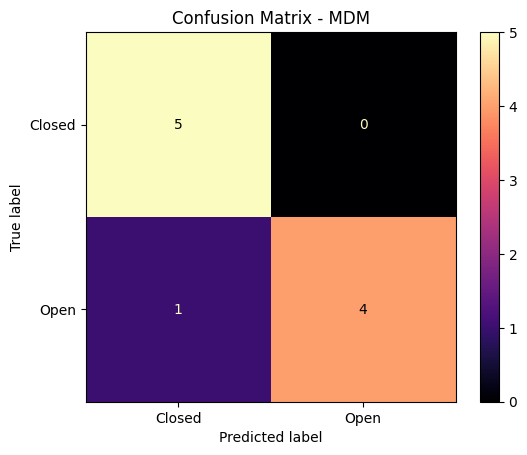

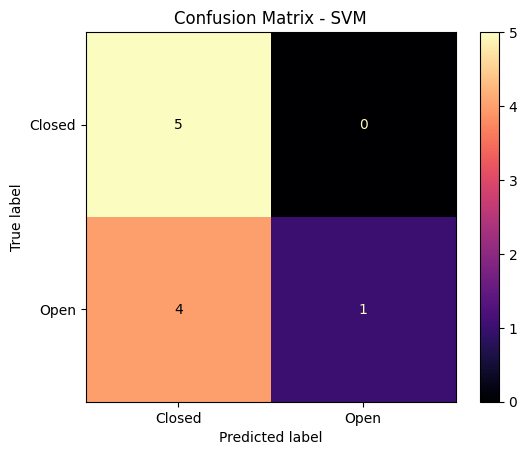

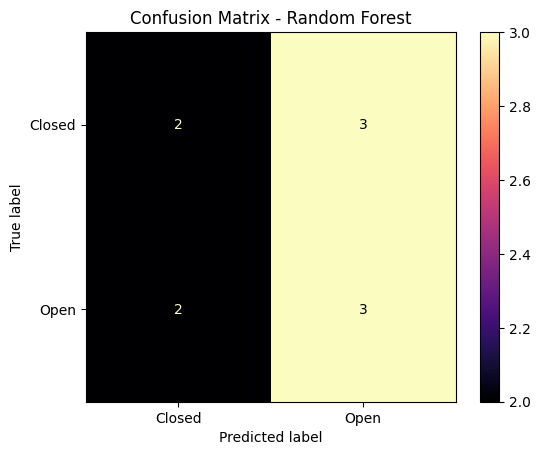

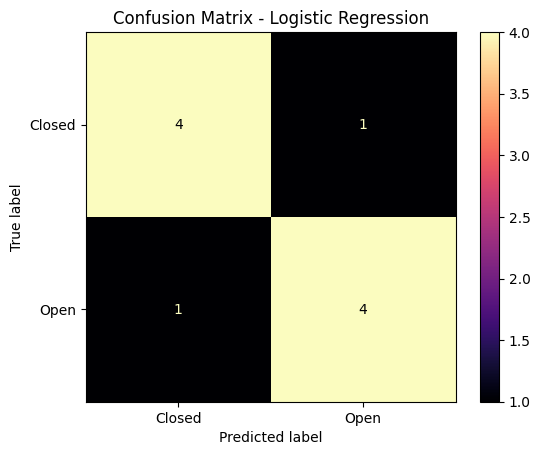

In [80]:
def plot_confusion(y_true, y_pred, classifier_name):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=['Closed', 'Open'])
    disp.plot(cmap=plt.cm.magma)
    plt.title(f'Confusion Matrix - {classifier_name}')
    plt.show()

plot_confusion(y, y_pred_mdm, "MDM")
plot_confusion(y, y_pred_svm, "SVM")
plot_confusion(y, y_pred_rf, "Random Forest")
plot_confusion(y, y_pred_lr, "Logistic Regression")